# Домашнее задание 3

# 1. Введение.

В этом разделе нам необходимо построить прогнозные модели для курсов валют. На семинарах мы обсуждали, что прогнозировать цены котировок стандартными линейными моделями довольно бесперспективно. Так как такие данные близки к модели случайного блуждания, оптимальным прогнозом для них часто оказывается наивный. Однако если перейти к более низкой частоте (например, к месячным данным), то некоторого превосходства над наивной всё же можно добиться.

В приложенном датасете currencies.csv находятся следующие величины:
1.  Курсы ряда валют по отношению к доллару. 

    Курс EUR/USD - Евро Доллар США
    
    Курс CNY/USD - Китайский юань Доллар США
    
    Курс INR/USD - Индийская рупия Доллар США
    
    Курс JPY/USD - Японская йена Доллар США
    
    Курс GBR/USD - Британский фунт Доллар США
    
    Курс CHF/USD - Швейцарский франк Доллар США
    
    Курс BRL/USD - Бразильский реал Доллар США
    
    Курс IDR/USD - Индонезийская рупия Доллар США

2. Цена нефти BRENT за баррель и цена газа в Европе за mmbtu (Британская тепловая единица)
3. ff_rate -- ставка ФРС США

Нашей задачей будет построить прогнозную модель для всех курсов валют из пункта 1. Цены нефти, газа и ставка ФРС даны дополнительно, можете использовать их если посчитаете необходимым, но в базовой версии можно использовать только временные ряды курсов валют.

### Импорт данных

Импортируйте данные из файла. Приведите информацию о датах в один столбец типа datetime. Например, чтобы каждая точка отображала дату начала месяца. 

In [221]:
import numpy as np
import pandas as pd
df = pd.read_csv('currencies.csv', sep=';')
df.head()

,Год,Квартал,Месяц,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate
0,2000,1,1,"25,38","3,36","1,013609524","0,12078434","0,022243451","0,949538799","1,640095238","0,6295","0,554614286","0,000137456","5,45"
1,2000,1,2,"27,7048","3,46","0,984514286","0,120800806","0,022339653","0,913322054","1,601461905","0,612571429","0,56327619","0,000134537","5,73"
2,2000,1,3,"27,47","3,51","0,965026087","0,120793942","0,022482895","0,940341532","1,581504348","0,601582609","0,574004348","0,000133953","5,85"
3,2000,2,4,"22,54","3,68","0,945325","0,120783377","0,022347401","0,946391847","1,58122","0,60119","0,565205","0,000128394","6,02"
4,2000,2,5,"27,34","3,55","0,90846087","0,120801494","0,022323287","0,924373862","1,50906087","0,583104348","0,54766087","0,000119977","6,27"


In [222]:
df['Год'] = df['Год'].astype(int)
df['Месяц'] = df['Месяц'].astype(int)
df['Дата'] = pd.to_datetime(df['Год'].astype(str) + '-' + df['Месяц'].astype(str) + '-01')
for col in df.columns.drop('Дата'):  
    if df[col].dtype == object:  
        df[col] = df[col].str.replace(',', '.').astype(float)
    else:
        df[col] = df[col].astype(float)
df.head()

,Год,Квартал,Месяц,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate,Дата
0,2000.0,1.0,1.0,25.3800,3.36,1.013610,0.120784,0.022243,0.949539,1.640095,0.629500,0.554614,0.000137,5.45,2000-01-01
1,2000.0,1.0,2.0,27.7048,3.46,0.984514,0.120801,0.022340,0.913322,1.601462,0.612571,0.563276,0.000135,5.73,2000-02-01
2,2000.0,1.0,3.0,27.4700,3.51,0.965026,0.120794,0.022483,0.940342,1.581504,0.601583,0.574004,0.000134,5.85,2000-03-01
3,2000.0,2.0,4.0,22.5400,3.68,0.945325,0.120783,0.022347,0.946392,1.581220,0.601190,0.565205,0.000128,6.02,2000-04-01
4,2000.0,2.0,5.0,27.3400,3.55,0.908461,0.120801,0.022323,0.924374,1.509061,0.583104,0.547661,0.000120,6.27,2000-05-01


Писать для каждого ряда одномерную модель несколько расточительно, хотя и не лишено смысла. Этот процесс необходимо автоматизировать. В простом для понимания варианте можно свести прогноз каждой валюты к табличной задаче и подобрать регрессоры из остальных рядов. Мы таким уже занимались, поэтому попробуем зайти с немного другой стороны.

Весь рынок и в частности рынок валют -- единый механизм, находящийся в некотором равновесии и иногда от него отклоняющийся. Значит, у рядов должен быть общий тренд. Формально такая ситуация называется коинтеграцией и это тема отдельной лекции, нам она будет нужна только для идеи. Более подробно про коинтеграцию можно почитать вот в этом [конспекте](https://vk.com/doc126754362_567660819?hash=AvDGHaO92KX7exjBCleLZsEGHPPX2iZfCqae2Fijkng). 

### 1. (0.5 балла) Визуализация

Давайте увидим это явно. Возьмите все курсы валют, отнормируйте их c помощью StandardScaler из sklearn и изобразите результат на одном графике. 

График будет немного шумный, но вы должны заметить что в целом валюты движутся по схожим траекториям, а некоторые группируются.

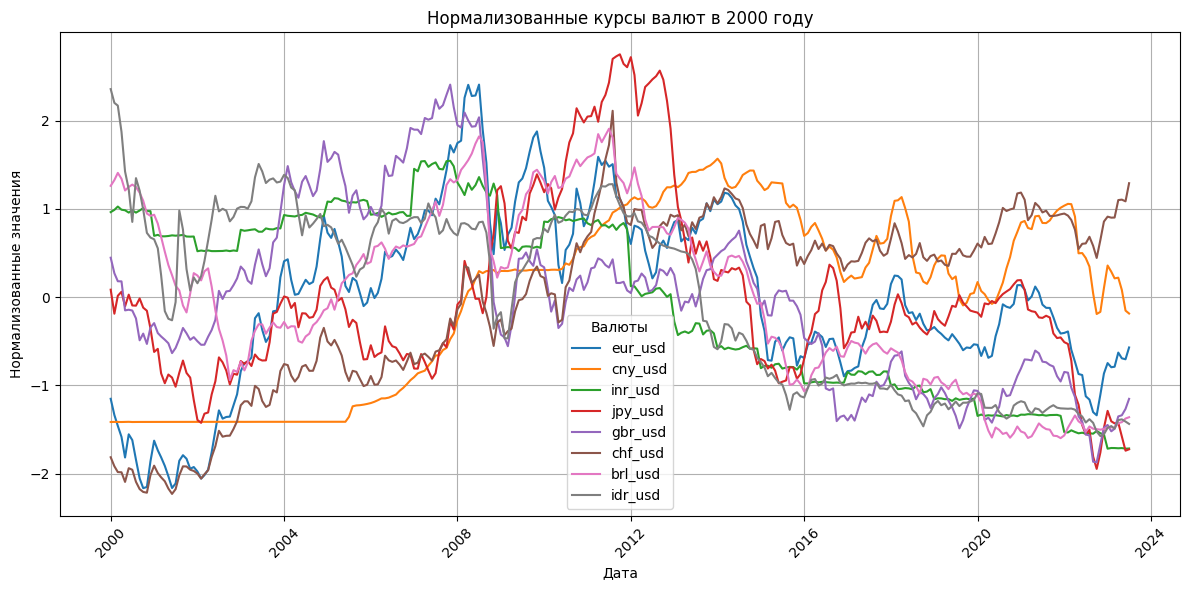

In [223]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

currency_columns = ['eur_usd', 'cny_usd', 'inr_usd', 'jpy_usd', 'gbr_usd', 'chf_usd', 'brl_usd', 'idr_usd']
currency_df = df[currency_columns]

scaler = StandardScaler()
scaled_currency_data = scaler.fit_transform(currency_df)
scaled_currency_df = pd.DataFrame(scaled_currency_data, columns=currency_columns, index=df['Дата'])

plt.figure(figsize=(12, 6))
for column in scaled_currency_df.columns:
    plt.plot(scaled_currency_df.index, scaled_currency_df[column], label=column)

plt.title('Нормализованные курсы валют в 2000 году')
plt.xlabel('Дата')
plt.ylabel('Нормализованные значения')
plt.legend(title="Валюты")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Можно ли выделить эти общие тренды на рынке? Да! Можно просто рассмотреть все валюты как один многомерный вектор и понизить его размерность.

Конечно, для временных рядов существуют специфические методы понижения размерности, но они выходят за рамки нашего курса. Поэтому мы воспользуемся не слишком подходящим, но зато простым и знакомым методом главных компонент (PCA). PCA никак не учитывает временную зависимость точек, но мы позволим себе пренебречь этим.

### 2. (0.5 балла) Визуализация главных компонент

Примените PCA на рядах из восьми валют и отберите три первые главные компоненты. Изобразите их на одном графике. Сравните с предыдущим графиком. Компоненты будут примерно похожи на тренды нескольких разных групп валют.

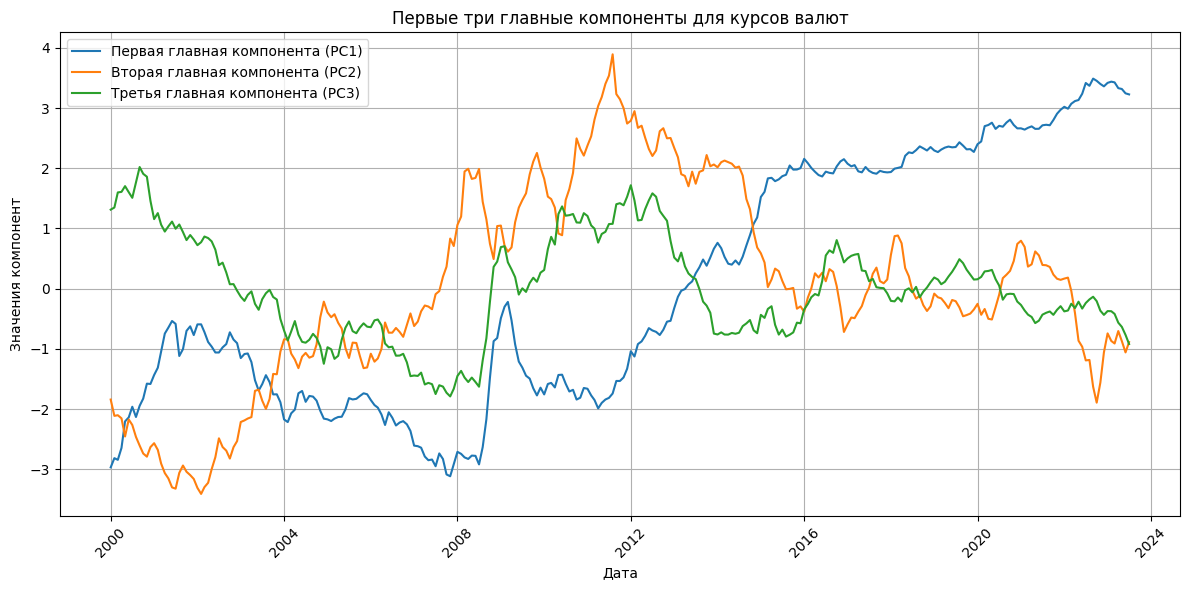

In [224]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_currency_data)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'], index=df['Дата'])

plt.figure(figsize=(12, 6))
plt.plot(pca_df.index, pca_df['PC1'], label='Первая главная компонента (PC1)')
plt.plot(pca_df.index, pca_df['PC2'], label='Вторая главная компонента (PC2)')
plt.plot(pca_df.index, pca_df['PC3'], label='Третья главная компонента (PC3)')

plt.title('Первые три главные компоненты для курсов валют')
plt.xlabel('Дата')
plt.ylabel('Значения компонент')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. VAR для каждой валюты

Хочется построить какую-то общую модель, которая учтёт эти тренды на рынке и позволит с её помощью прогнозирвать отдельные валюты. Мы проходили только VAR(p) из прогнозирующих моделей, но её достаточно в большинстве случаев. Также мы обсуждали, что количество параметров в VAR(p)-модели равно 

$$n^2 p + n + \frac{n(n+1)}{2},$$

где n число уравнений системы. Данное выражение растёт квадратично по n. Значит, количество уравнений нам бы хотелось минимизировать. У нас в наличии 8 валют и ещё потенциально 3 дополнительных переменных. Это слишком много для стандартной VAR-модели, необходимо сократить размерность.

Будем для каждой валюты строить VAR(p) модель со следующими рядами: ряд этой валюты + из всех остальных рядов выделим PCA-компоненты. Дальнейшие шаги необходимо будет сделать для каждой из валют в списке, поэтому рекомендуется заранее писать код так, чтобы его было легко встроить в цикл. Например, разбивать код на функции и т.п. В качестве референса предлагается заполнить класс PartialForecaster. Это будет класс для прогнозирвоания одной валюты на основе всех остальных. Ваша реализация может отличаться, меняйте параметры или добавляйте свои методы в класс если необходимо.

1. (0.5 балла) Реализуйте метод fit_pca, который вычисляет главные компоненты от фичей и сохраняет их. Компоненты должны покрывать 95% дисперсии оригинальных данных. Не добавьте в вычисление PCA целевую фичу, это будет сильная утечка!

2. (0.5 балла) Реализуйте метод fit_var. В нём необходимо склеить целевую переменную и полученные главные компоненты в один датасет и обучить на этом VAR(p)-модель.

    Важное замечание. По-хорошему нужно оценивать модель на стационарных данных. Если бы мы оценивали модель методом максимального правдоподобия с ограничениями на стационарность, то ничего хорошего бы не вышло, коэффициенты бы сели на границу этого ограничения. Но так как в statsmodels (да и в целом чаще всего) модель оценивается методом наименьших квадратов и без ограничений на параметры, это можно проигнорировать в нашем случае. Для прогнозирования особой разницы не будет, но часть статистических тестов работать перестанет из-за возможных смещений в распределениях оценок параметров.

3. (0.5 балла) Реализуйте метод forecast. По сути нужно просто спрогнозировать VAR и достать из прогноза только один ряд для нужной валюты.



In [225]:
df = df.drop(['Год', 'Квартал', 'Месяц'], axis=1)
df.set_index('Дата', inplace=True)
df.head()

,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate
Дата,,,,,,,,,,,
2000-01-01,25.3800,3.36,1.013610,0.120784,0.022243,0.949539,1.640095,0.629500,0.554614,0.000137,5.45
2000-02-01,27.7048,3.46,0.984514,0.120801,0.022340,0.913322,1.601462,0.612571,0.563276,0.000135,5.73
2000-03-01,27.4700,3.51,0.965026,0.120794,0.022483,0.940342,1.581504,0.601583,0.574004,0.000134,5.85
2000-04-01,22.5400,3.68,0.945325,0.120783,0.022347,0.946392,1.581220,0.601190,0.565205,0.000128,6.02
2000-05-01,27.3400,3.55,0.908461,0.120801,0.022323,0.924374,1.509061,0.583104,0.547661,0.000120,6.27


In [226]:
from statsmodels.tsa.api import VAR
import pandas as pd

class PartialForecaster:
    
    def __init__(self, data:pd.DataFrame, target_feature: str, p: int | None = None):
        """
        __init__ Initializing forecaster class

        Arguments:
            data {pd.DataFrame} -- Dataframe of all data
            target_feature {str} -- Target feature of dataframe. Other features in dataframe will be regressors
            p {int} -- Order of VAR model
        """
        self.is_pca_fitted = False
        self.is_var_fitted = False

        assert target_feature in data.columns

        self.data = data 
        self.target_feature = target_feature
        self.p = p
        self.model = None
        self.pca_components = None

        
        
    def fit_pca(self, covered_variance=0.95) -> pd.DataFrame:
        """
        fit_pca _summary_

        Arguments:
            features {pd.DataFrame} -- Dataframe of features

        Keyword Arguments:
            covered_variance {float} -- Share of variance, covered by PCA from original data. (default: {0.95})

        Returns:
            pd.DataFrame -- Dataframe of principal components
        """
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.data)
        df = pd.DataFrame(scaled_data, columns=self.data.columns, index=self.data.index)
        
        features = df.drop(columns=[self.target_feature])
        self.pca = PCA(n_components=covered_variance)
        self.pca_components = self.pca.fit_transform(features)
        self.is_pca_fitted = True
        return pd.DataFrame(self.pca_components)


    def fit_var(self):

        """
         Fitting var on results of PCA
        """

        assert self.is_pca_fitted

        combined_data = np.hstack((self.data[[self.target_feature]].values, self.pca_components))
        columns = [self.target_feature] + [f'PC{i+1}' for i in range(self.pca_components.shape[1])]
        combined_df = pd.DataFrame(combined_data, index=self.data.index, columns=columns)
        self.combined_df = combined_df
        self.model = VAR(combined_df)
        if self.p != None:
            self.model = self.model.fit(self.p)
        else:
            self.model = self.model.fit(ic='bic')
            self.p = self.model.k_ar
        self.is_var_fitted = True

    def p_define(self):
        assert self.is_var_fitted
        return self.p

    def forecast(self, h=12):
        assert self.is_var_fitted
        lag_order = self.model.k_ar
        result = self.model.forecast(self.combined_df.values[-lag_order:], steps=h)
        forecast = pd.Series(result[:, 0], index=pd.date_range(start=self.data.index[-1], periods=h+1, freq='M')[1:], name=self.target_feature)
    
        return forecast

In [227]:
model = PartialForecaster(df, 'gbr_usd')
model.fit_pca()
model.fit_var()
model.forecast()

c:\Users\rusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-08-31    1.292972
2023-09-30    1.297088
2023-10-31    1.301216
2023-11-30    1.305346
2023-12-31    1.309468
2024-01-31    1.313572
2024-02-29    1.317651
2024-03-31    1.321697
2024-04-30    1.325704
2024-05-31    1.329667
2024-06-30    1.333580
2024-07-31    1.337439
Freq: M, Name: gbr_usd, dtype: float64

In [228]:
model.p_define()

1

5. (1 балл) Отберите параметр p и посчитайте прогнозную ошибку такого метода для каждой валюты. 

    Предлагается следующая процедура.

    1. Выбираем некоторое стартовое окно. У нас 283 точки. 36 (12*3) последних точек выделим на тестовую часть, остальное на тренировочную.
    2. На тренировочной части выбираем p по информационному критерию. В классе выше это означает p = None

    Далее попробуем получить наиболее репрезентативную оценку ошибки для такого p. Мы будем сразу считать относительную ошибку в сравнении с наивной моделью, так как на котировках часто нельзя построить статистическую модель лучше наивной. 

    1. Прогнозируем полученной моделью на 12 шагов вперёд.
    2. Считаем абсолютную ошибку прогноза (вектор длины 12)
    3. Строим наивный прогноз
    4. Считаем абсолютную ошибку наивного прогноза
    5. Считаем отношение ошибки нашего прогноза к наивной ошибке, сохраняем этот вектор длины 12
    7. Увеличиваем тренировочную выборку на 6 наблюдений. Переоцениваем всю модель на новых данных, но уже при фиксированном p. В классе выше это будет p={некоторое число}

    Повторяем эту процедуру пока не закончатся данные. При текущих параметрах получится 4 итерации. Усредняем вектора ошибок по всем итерациям. Итого получаем усреднённый вектор длины 12. Параметры можете поменять по собственным соображениям, но поясните логику.


In [229]:
def relative_score_partial(df, currency_columns, initial_window_size=247, step=6, horizon=12):
    relative_errors = {currency: [] for currency in currency_columns}  
    score = []

    for target_feature in currency_columns:
        initial_data = df.iloc[:initial_window_size]
        total_points = df.shape[0]
        
        model = PartialForecaster(initial_data, target_feature)
        model.fit_pca()
        model.fit_var()
        best_p = model.p_define()
        
        metric_one = []
        
        for start in range(initial_window_size, total_points - horizon, step):
            train = df.iloc[:start]
            test = df.iloc[start:start + horizon]
            model = PartialForecaster(train, target_feature, p=best_p)
            model.fit_pca()
            model.fit_var()

            forecast = model.forecast(horizon)
            actual = test[target_feature].values

            last_observed_value = train[target_feature].iloc[-1] 
            naive_forecast = pd.Series([last_observed_value] * horizon)

            absolute_error_model = np.abs(np.array(forecast) - np.array(actual))
            absolute_error_naive = np.abs(np.array(naive_forecast) - np.array(actual))

            error_ratio = absolute_error_model/absolute_error_naive

            relative_errors[target_feature].append(error_ratio)
        
    for currency in currency_columns:
        error_one = np.mean(np.array(relative_errors[currency]), axis=0)
        relative_errors[currency] = error_one

    error_df = pd.DataFrame(relative_errors, index=[f'Horizon {i+1}' for i in range(horizon)])
    return error_df 

score = relative_score_partial(df, currency_columns)

c:\Users\rusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rusta\AppData\Local\Programs\Python\Python311\L

In [230]:
score

,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
Horizon 1,1.974014,4.355865,6.810452,2.919774,3.160243,0.906680,1.456322,7.973581
Horizon 2,0.637923,1.744588,10.535719,7.118330,0.542792,0.701921,1.895442,391.431321
Horizon 3,0.601449,1.523881,110.233781,0.705822,0.515878,0.759296,1.804465,5.327735
Horizon 4,1.271579,0.948605,inf,0.634773,0.404464,0.774776,3.503396,2.070664
Horizon 5,0.778229,0.927451,20.391602,0.708458,0.421275,0.672089,1.685929,1.989980
Horizon 6,0.701206,6.523264,8.471170,0.675173,0.367477,0.861952,4.668553,1.814271
Horizon 7,0.638694,5.224771,12.865370,0.906802,0.372879,0.665795,5.416004,2.330739
Horizon 8,0.613605,1.716391,10.343635,0.274389,0.589885,0.637958,4.256530,4.284553
Horizon 9,0.612770,0.748435,14.965964,0.387988,1.163070,0.802112,3.933578,6.170545
Horizon 10,0.580641,0.899409,19.447257,0.391502,0.851122,0.806248,19.635843,5.916461


6. (0.5 балла) Постройте линейный график скоров. Можно строить любой другой график кроме линейного, если он будет более интерпретируем. Простор для творчества!

    1.  Каждая валюта представлена линией на графике
    2.  По оси абсцисс идёт горизонт прогнозирования (от 1 до 12)
    3.  По оси ординат отношение ошибки VAR-модели к ошибке наивной модели

Получилось ли по какой-то валюте стабильно предсказывать лучше наивной на всех горизонтах. По каким валютам получилось лучше, по каким хуже?

У нас получалось, что на сильно зарегулированных экономиках (например, Китай) прогнозы близки к наивным, так как курс валюты сильнее зависит от решений партии, а не внешней обстановки. Но в целом у вас может получиться и другой результат.

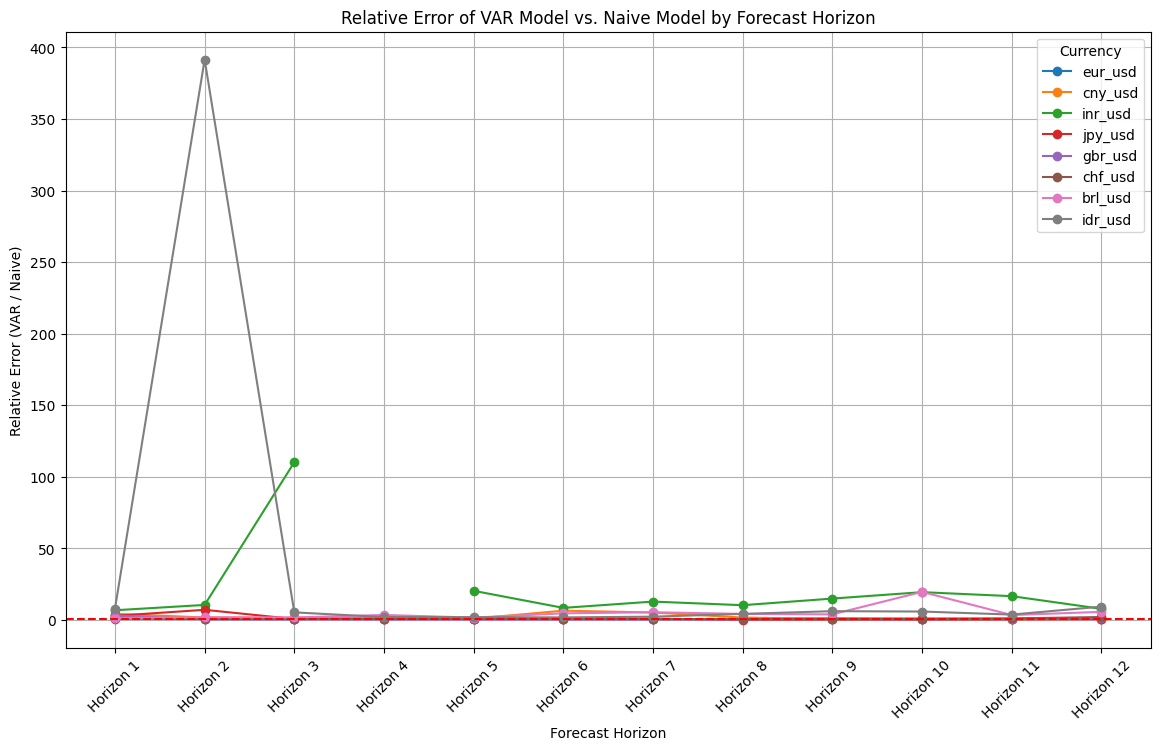

In [231]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for column in score.columns:
    plt.plot(score.index, score[column], marker='o', label=column)

plt.title('Relative Error of VAR Model vs. Naive Model by Forecast Horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('Relative Error (VAR / Naive)')
plt.legend(title='Currency')
plt.grid(True)
plt.xticks(rotation=45)


plt.axhline(y=1, color='r', linestyle='--')  

plt.show()


*Очень плохо получилось спрогнозировать индонейзийскую рупию и индийскую рупию, на них относительные ошибки крайне велики, на индийской рупии даже улетает в бесконечность. Из-за масштаба тяжело выделить хорошие прогнозы, однако видно, что прогнозы Японской йены, Китайского юаня, Евро, Британского фунта и Швейцарского франка не отличались высокой относительной ошибкой*

# 3. Автокодировщик на стероидах

Можно построить альтернативный вариант.

1. Энкодер. Строим PCA на всех валютах (и доп фичах, если хотите) сразу, выделяем главные компоненты.
2. Декодер. PCA не обратим в стандартном понимании, нельзя аналитически получить из главных компонент обратно исходные ряды. Для каждой валюты обучаем регрессионную модель, предсказывающую курс валюты по главным компонентам. Если у нас 8 валют, здесь получится 8 моделей. Модели можно взять любые (линрег, бустинг, ...). Не мучайтесь с подбором гиперпараметров, бустинга из коробки хватит.
2. Строим VAR(p)-модель только на главных компонентах, отобрав p
4. Прогнозируем главные компоненты вперёд
5. Применяем модели-декодеры, чтобы получить из прогнозов главных компоненты прогнозы валют


1. (0.5 балла) Реализуйте метод fit_pca, который вычисляет главные компоненты от всех валют и дополнительных переменных и сохраняет их. Компоненты должны покрывать 95% дисперсии оригинальных данных.

2. (0.5 балла) Реализуйте метод fit_var. В нём необходимо обучить VAR(p)-модель на главных компонентах из предыдущего пункта.

3. (1 балл) Реализуйте метод fit_decoders. Необходимо оценить ряд регрессий, восстанавливающих валюты из главных компонент. Восстанавливать дополнительные переменные не нужно. Заморачиваться с отбором параметров этих моделей не нужно (только при большом желании). Бустинга из коробки должно хватить.

4. (0.5 балла) Реализуйте метод forecast. VAR прогнозируют главные компоненты, а модели-декодеры восстанавливают из этих прогнозов валюты. Функция должна возвращать датафрейм прогнозов всех валют на 12 шагов. По колонкам идут валюты, по строкам горизонты.

In [232]:
from statsmodels.tsa.api import VAR
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

class EncoderDecoderForecaster:
    
    def __init__(self, data:pd.DataFrame, target_features: list, p: int|None = None):
        """
        __init__ Initializing forecaster class

        Arguments:
            data {pd.DataFrame} -- Dataframe of all data
            target_feature {str} -- Target feature of dataframe. Other features in dataframe will be regressors
            p {int} -- Order of VAR model
        """
        self.is_pca_fitted = False
        self.is_var_fitted = False

        # assert target_features in data.columns

        self.data = data 
        self.target_features = target_features
        self.p = p

        self.is_decoder_fitted = False
        self.pca = None
        self.model = None
        self.model_fit = None
        self.pca_components = None
        self.decoders = {}

        
        
    def fit_pca(self, covered_variance=0.95) -> pd.DataFrame:
        """
        fit_pca Fitting PCA on a bunch of currencies

        Arguments:
            features {pd.DataFrame} -- Dataframe of features

        Keyword Arguments:
            covered_variance {float} -- Share of variance, covered by PCA from original data. (default: {0.95})

        Returns:
            pd.DataFrame -- Dataframe of principal components
        """
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.data)
        data = pd.DataFrame(scaled_data, columns=self.data.columns, index=self.data.index)
        
        self.pca = PCA(n_components=covered_variance)
        self.pca_components = self.pca.fit_transform(data)
        self.is_pca_fitted = True
        return pd.DataFrame(self.pca_components, columns=[f'PC{i+1}' for i in range(self.pca_components.shape[1])])


    def fit_var(self):

        """
         Fitting var on results of PCA
        """

        assert self.is_pca_fitted
        self.model = VAR(pd.DataFrame(self.pca_components))
        self.model_fit = self.model.fit(self.p, ic='bic')
        p = self.model_fit.k_ar
        self.is_var_fitted = True
        return p


    def fit_decoders(self):

        self.decoders = {}
        for feature in self.target_features:
            decoder = GradientBoostingRegressor()
            decoder.fit(self.pca_components, self.data[feature])
            self.decoders[feature] = decoder
        self.is_decoder_fitted = True

        assert len(self.decoders) > 0


    def forecast(self, h: int = 12) -> pd.Series:
        """
        forecast Forecast VAR and decode it's forecasts with decoder-models.

        Keyword Arguments:
            h {int} -- Forecasting horizon (default: {1})

        Returns:
            pd.DataFrame -- Forecasts of all currencies. Horizon by rows. Currencies by columns.
        """

        assert self.is_pca_fitted and self.is_var_fitted and self.is_decoder_fitted

        forecast_pca = self.model_fit.forecast(self.pca_components[-self.model_fit.k_ar:], steps=h)
        forecast = {currency: self.decoders[currency].predict(forecast_pca) for currency in self.decoders}
        forecast_df = pd.DataFrame(forecast, index=[f'Horizon {i+1}' for i in range(0, h)])
    
        return forecast_df

In [233]:
model = EncoderDecoderForecaster(df, currency_columns)
model.fit_pca()
model.fit_var()
model.fit_decoders()
model.forecast()

,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
Horizon 1,1.099083,0.140152,0.012213,0.707581,1.302644,1.132865,0.201471,0.000066
Horizon 2,1.099083,0.143272,0.012213,0.706807,1.302644,1.120223,0.201471,0.000066
Horizon 3,1.099083,0.141994,0.012236,0.708706,1.302644,1.120223,0.199744,0.000066
Horizon 4,1.097800,0.142183,0.012236,0.699890,1.304378,1.120223,0.199744,0.000066
Horizon 5,1.098592,0.142183,0.012653,0.734702,1.303880,1.096632,0.197749,0.000066
Horizon 6,1.098592,0.142476,0.012653,0.734702,1.303880,1.095896,0.194502,0.000066
Horizon 7,1.098592,0.142476,0.012596,0.734702,1.303880,1.095918,0.194502,0.000066
Horizon 8,1.098592,0.142476,0.012748,0.746253,1.303880,1.088554,0.195862,0.000066
Horizon 9,1.093700,0.143095,0.012575,0.736023,1.303880,1.087027,0.195862,0.000067
Horizon 10,1.094538,0.143184,0.012575,0.741865,1.303880,1.085345,0.195862,0.000066


5. (1 балл) Аналогично предыдущей части, подсчитайте относительную ошибку по всем валютам. Отличие будет только в том, что в этот раз класс EncoderDecoderForecaster возвращает прогнозы по всем валютам сразу. В данном случае итог будет сразу датафреймом. По колонкам будут валюты, по строкам горизонты. Параметр p отберите на тренировочной выборке и усредните относительную ошибку прогноза (усреднить датафреймы поэлементно) по всем окнам.

In [234]:
def relative_cross_val_score_encoder_decoder(data: pd.DataFrame, initial_window_size: int, step: int, p:int, horizon: int = 12) -> pd.Series:
    """
    cross_val_score Estimating MAE cross-val score on a fitted model. Needed to get more sustainable MAE estimation

    Arguments:
        initial_window_size {int} -- Initial size of expanding window
        step {int} -- Step size of expanding window
        horizon {int} -- Forecasting horizon of cross-validation score
        p {int} -- order of VAR model
    Returns:
        pd.DataFrame -- Frame of absolute error by each horizon and each currency, averaged by several folds
    """
    total_points = data.shape[0]
    errors = [] 
    initial = data.iloc[:initial_window_size]
    first = EncoderDecoderForecaster(initial, currency_columns)
    first.fit_pca()
    p_best = first.fit_var()
    print(p_best)
    


    for start in range(initial_window_size, total_points - horizon, step):
        train = data.iloc[:start]
        test = data.iloc[start:start + horizon]

        model = EncoderDecoderForecaster(train, currency_columns, p=p_best)
        model.fit_pca()
        model.fit_var()
        model.fit_decoders()

        forecast = np.array(model.forecast(horizon))
        
        # naive_forecasts = np.array(train[currency_columns].iloc[-horizon:])

        last_observed_value = train[currency_columns].iloc[-1]  

        naive_forecasts = np.array([last_observed_value] * horizon)

        y_test = np.array(test[currency_columns])


        model_errors = np.abs(forecast-y_test)
        naive_errors = np.abs(naive_forecasts-y_test)

        error_ratio = model_errors/naive_errors
        errors.append(error_ratio)
        
    stacked_matrices = np.stack(errors)
    average_matrix = np.mean(stacked_matrices, axis=0)

    return pd.DataFrame(average_matrix, index=[f'Horizon {i+1}' for i in range(horizon)], columns=currency_columns)

In [235]:
score = relative_cross_val_score_encoder_decoder(df, 247, 6, None, 12)
score

2


C:\Users\rusta\AppData\Local\Temp\ipykernel_1640\3885978586.py:46: RuntimeWarning: divide by zero encountered in divide
  error_ratio = model_errors/naive_errors


,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
Horizon 1,2.729339,15.528651,30.213850,2.821193,2.366894,3.172126,10.009622,5.258276
Horizon 2,1.285192,2.148540,15.624894,4.894665,0.976349,1.086996,5.016000,74.005444
Horizon 3,1.384872,0.978582,44.432383,1.027520,1.112178,1.294554,3.698927,1.950068
Horizon 4,1.733639,0.627256,inf,1.020889,0.925504,1.939211,9.451615,1.551258
Horizon 5,1.294386,0.652873,15.087212,1.003616,0.923932,1.142961,2.734720,1.533150
Horizon 6,1.247304,7.172671,10.102058,0.929635,1.262906,1.161893,6.647450,1.371186
Horizon 7,1.283768,5.670915,8.807837,1.223607,1.329479,1.291899,8.382249,1.504698
Horizon 8,1.298243,1.549703,11.497517,0.814084,1.713294,2.870449,7.796438,2.659521
Horizon 9,1.259290,0.598719,12.372568,0.858269,2.455324,1.660983,4.947887,4.104702
Horizon 10,1.234485,0.735044,15.920556,0.917369,1.441945,1.141287,21.260944,2.703305


6. (0.5 балла) Постройте график относительных ошибок аналогично предыдущей части. Получилось ли добиться улучшения относительно предыдущей модели? Результат здесь не очевиден, метод может оказаться как лучше, так и хуже.

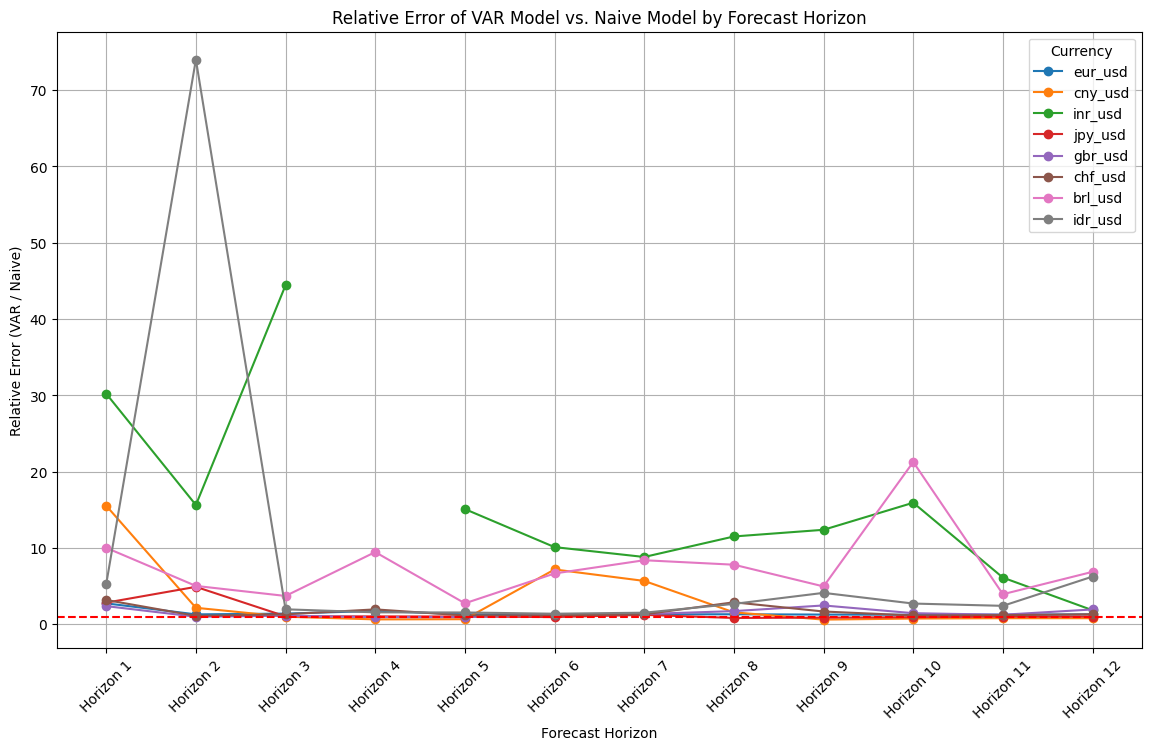

In [236]:
plt.figure(figsize=(14, 8))
for column in score.columns:
    plt.plot(score.index, score[column], marker='o', label=column)

plt.title('Relative Error of VAR Model vs. Naive Model by Forecast Horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('Relative Error (VAR / Naive)')
plt.legend(title='Currency')
plt.grid(True)
plt.xticks(rotation=45)


plt.axhline(y=1, color='r', linestyle='--')  

plt.show()

*Как видно, результат улучшить не получилось. Как видно, аналогично прошлой модели, наиболее плохие результаты получились при предсказании индийской и индонезийской рупии, относительно неплохими получились прогнозы йены, франка, фунта*

# Расширения модели (2 балла)

Придумайте способ добавить в PCA (t-sne или любой другой кросс-секционный метод) зависимость от времени. Либо найдите метод понижения размерности специально для временных рядов. Кратко опишите суть и примените его для обоих классов выше вместо PCA. Получилось ли улучшить качество модели?

1. (1 балл) Ваше краткое описание методики и почему она подходит для рядов. Если есть статьи, можете приложить ссылки.

2. (1 балл) Реализация для обеих вариантов, подсчёт метрик и анализ результата.

# Часть 1.
## Singular Spectrum Analysis (SSA)

**Singular Spectrum Analysis (SSA)** — это метод анализа временных рядов, который используется для изучения структуры, предсказания и даже восстановления данных во временных рядах. SSA работает путем разложения временного ряда на сумму интерпретируемых компонентов, таких как тренд, периодические колебания и шумовые компоненты. подробнее тут - https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition

## Суть SSA

### 1.Вложение
SSA начинается с создания **матрицы траекторий** из временного ряда путем "вложения" данных в многомерное пространство с использованием окон заданного размера. Это преобразует одномерный временной ряд в матрицу, которая отражает его внутреннюю структуру.

### 2.Сингулярное разложение
Применяется **сингулярное разложение (SVD)** к этой матрице траекторий, что дает ряд сингулярных значений и соответствующих им компонент. Это разложение позволяет выделить вклады различных составляющих временного ряда.

### 3.Группировка
Компоненты, полученные после SVD, группируются по интересующим категориям (например, тренд, сезонность, шум), что позволяет отдельно анализировать влияние каждого из этих факторов на временной ряд.

### 4.Диагональное усреднение
Процесс обратного преобразования отдельных групп компонентов в временной ряд, которое дает возможность реконструировать его составляющие или делать прогноз.

В отличие от **PCA**, который ориентирован на извлечение основных направлений дисперсии в многомерных данных и не учитывает временную структуру данных, SSA специально разработан для работы с временными рядами, учитывая их последовательность и внутреннюю связь.

SSA чаще всего используется для разложения одного временного ряда на несколько компонент, чтобы учесть временную структуру, затем наиболее важные компоненты отбираются через PCA, чтобы учитывать нелинейные зависимости, можно использовать KernelPCA.

Расширением SSA стало **Multivariate Singular Spectrum Analysis (mSSA)**. mSSA расширяет идеи SSA для анализа множества связанных временных рядов одновременно. Он учитывает корреляции между различными временными рядами, обеспечивая более глубокий и комплексный анализ. Подробнее можно ознакомиться тут: https://www.researchgate.net/publication/263870252_Multivariate_singular_spectrum_analysis_A_general_view_and_new_vector_forecasting_approach. 

Для решения задачи учета временных связей и при этом при необходимости сохранения низкой размерности я решил применить mSSA к данным, а затем аналогично прудыдущим подходам отобрать самые значимые компоненты из полученных компонент временных рядов самые значимые с помощью KernelPCA.

Чтобы самостоятельно написать реализацию mSSA, боюсь не хватит и месяца, поэтому я нашел реализацию энтузиаста с подробным описанием использования: https://github.com/kieferk/pymssa?tab=readme-ov-file.

Описание использование и иллюстрацию разбивки на компоненты можно найти ниже.

In [237]:
from pymssa import MSSA

In [238]:
scaler = StandardScaler()
df_diff = df.diff()[1:] 
scaled_data = scaler.fit_transform(df_diff) 
data = pd.DataFrame(scaled_data, columns=df.columns, index=df_diff.index)
data.head()

,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate
Дата,,,,,,,,,,,
2000-02-01,0.359685,0.027481,-1.090879,-0.040351,0.409120,-1.673156,-1.130603,-0.885010,0.661216,-1.019875,1.492556
2000-03-01,-0.072391,0.009880,-0.734670,-0.059768,0.554730,1.318669,-0.565851,-0.604767,0.799355,-0.126981,0.643217
2000-04-01,-0.864970,0.052123,-0.742563,-0.062848,-0.308083,0.326578,0.029063,-0.104826,-0.506151,-2.029400,0.908635
2000-05-01,0.777514,-0.053485,-1.378933,-0.038977,0.036688,-1.001386,-2.144416,-0.939603,-1.090781,-3.122288,1.333305
2000-06-01,0.361795,0.009880,1.526242,-0.043812,-0.197542,0.876901,0.086267,1.130549,0.431476,-1.357913,1.386389


In [239]:
mssa = MSSA(n_components=None,
 window_size=None,
 verbose=True)
mssa.fit(data)

Constructing trajectory matrix
Trajectory matrix shape: (1551, 142)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


In [240]:
mssa.components_

array([[[ 1.44485513e-02,  1.51881569e-01,  3.45068572e-03, ...,
         -2.33155251e-02,  1.32741461e-02, -1.32738127e-02],
        [ 5.68817908e-03,  1.55072872e-01,  1.55123930e-03, ...,
          3.13382135e-02, -1.19326156e-02,  2.02649473e-02],
        [-1.04927400e-02,  1.43085086e-01,  6.29022758e-03, ...,
         -3.07611159e-02,  8.36108363e-03, -2.50045785e-02],
        ...,
        [-8.12989278e-03,  3.55357054e-03, -9.60308588e-03, ...,
          1.28854228e-02,  8.08009855e-03, -4.70975136e-02],
        [-1.11979570e-02,  1.99422659e-03, -7.12779791e-03, ...,
         -3.43171558e-03, -8.76163595e-03,  3.97579961e-02],
        [-1.23162761e-02, -2.46806875e-04, -4.91700856e-03, ...,
         -1.36855049e-03,  1.14397718e-02, -3.07609557e-02]],

       [[-3.73720043e-03,  1.32389202e-02,  1.61541026e-02, ...,
          6.39417742e-04, -2.35756071e-03,  5.63848752e-06],
        [ 8.34867134e-06,  1.73373203e-02,  1.86644719e-02, ...,
         -7.01026754e-04,  1.87094435e

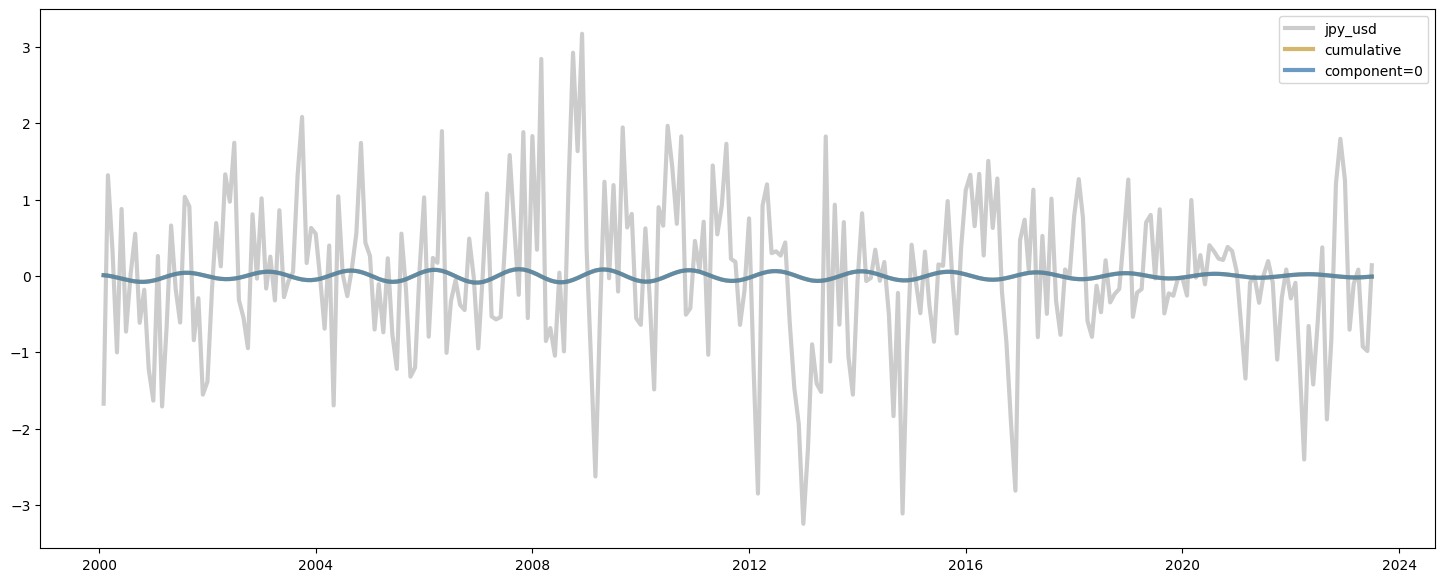

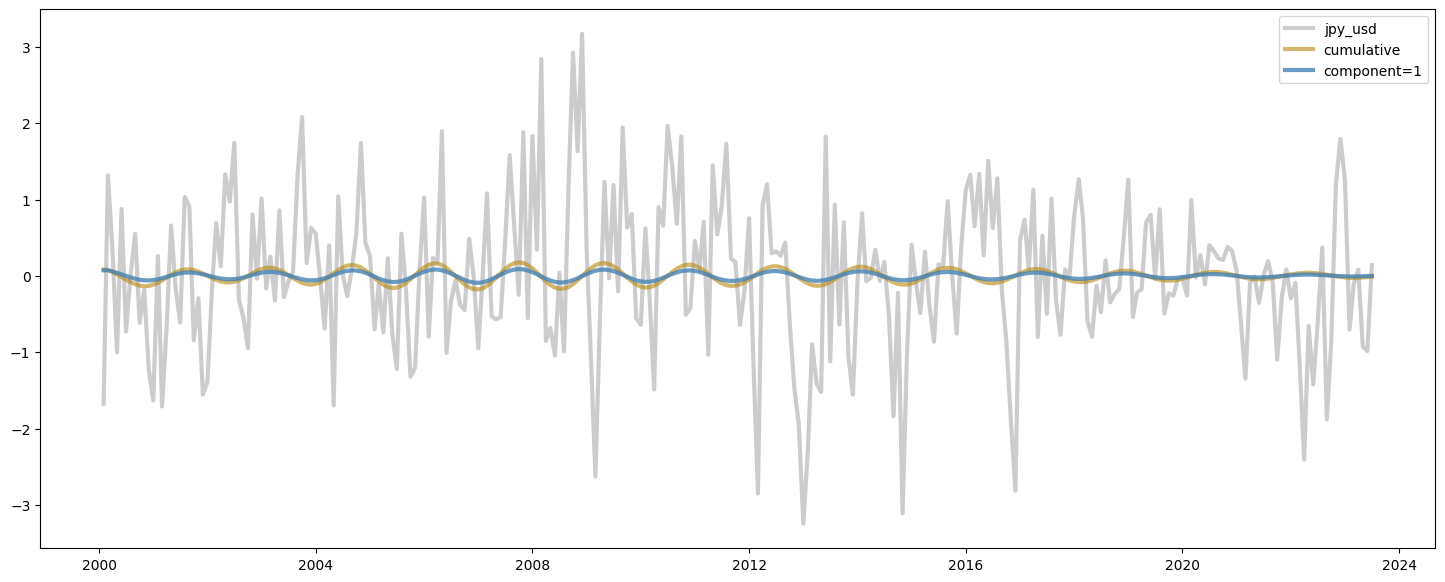

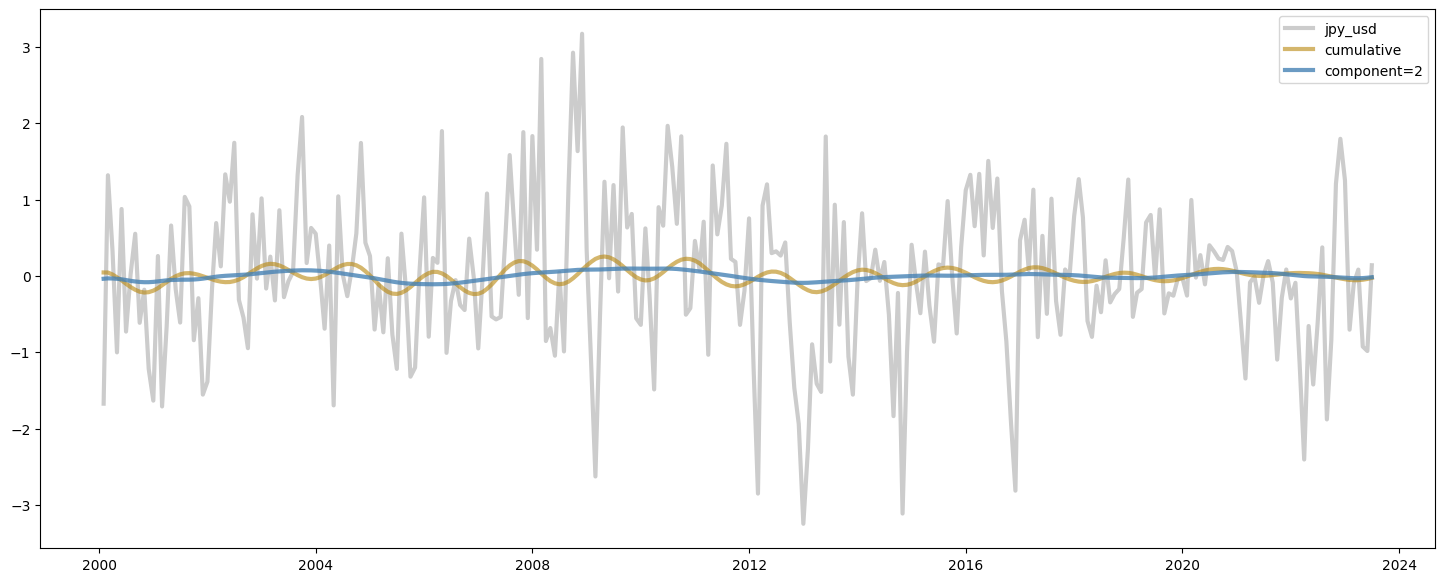

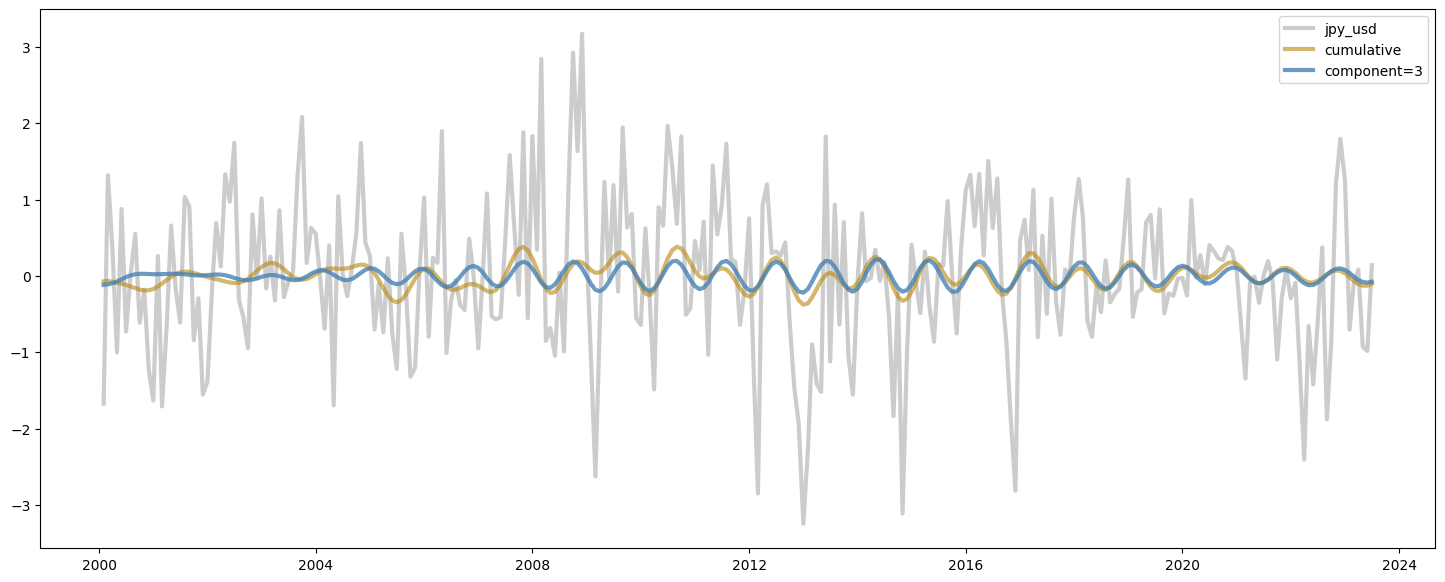

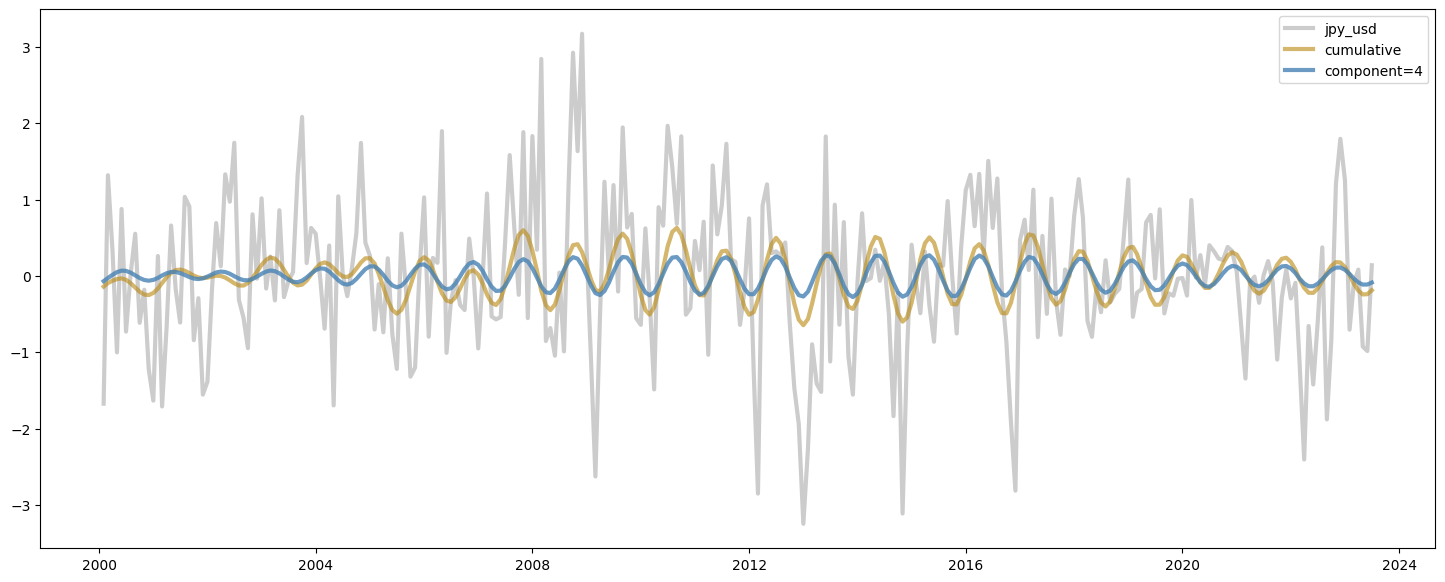

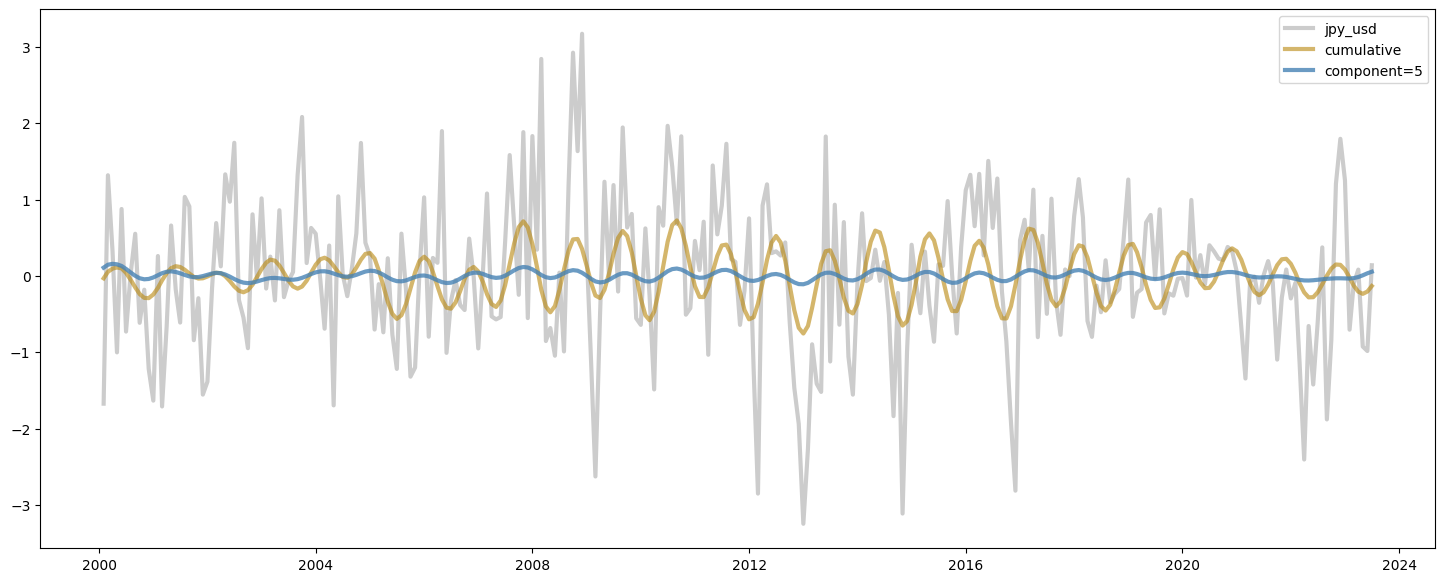

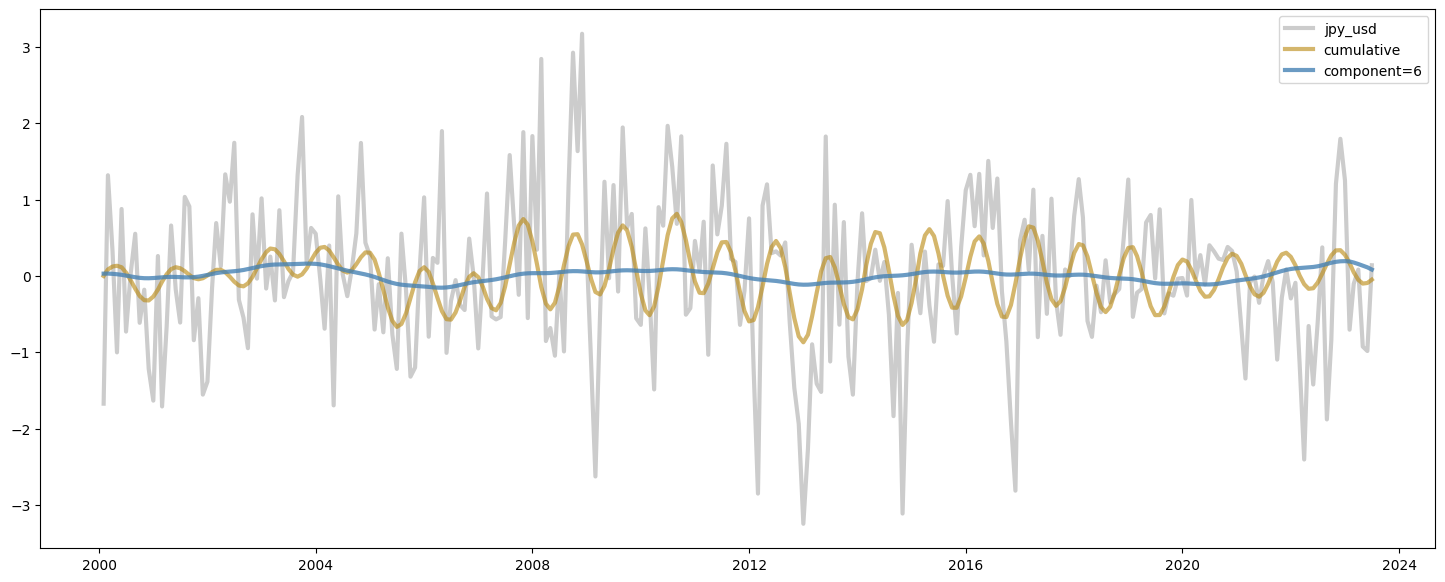

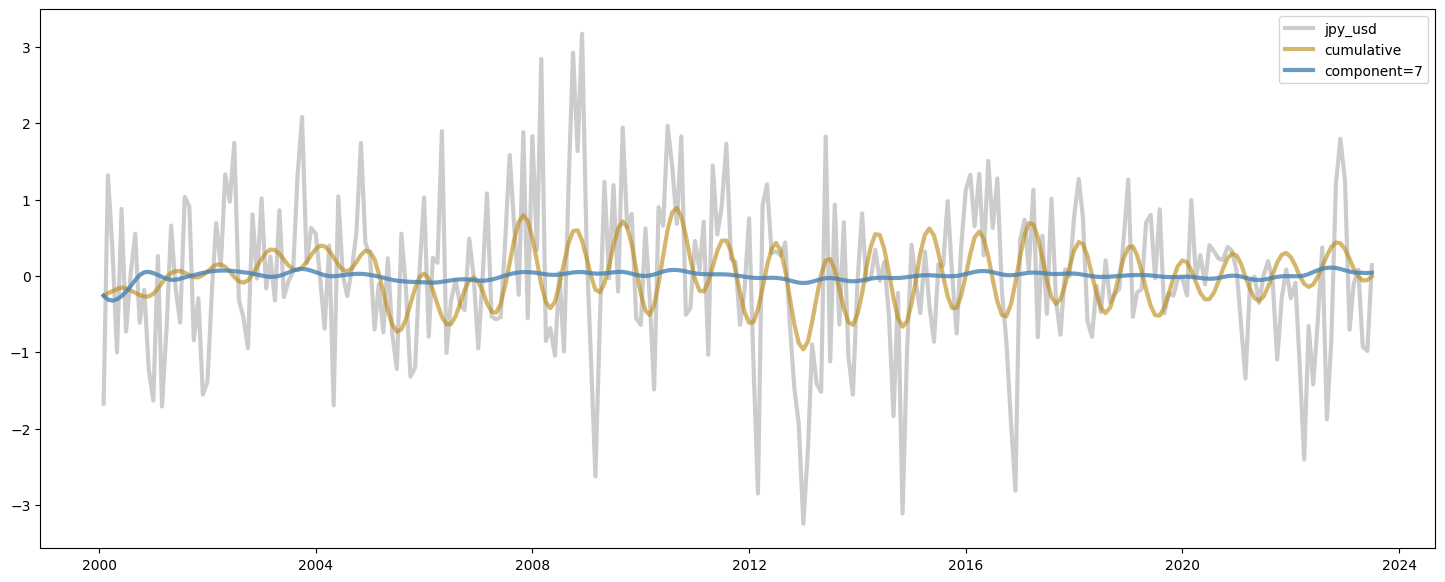

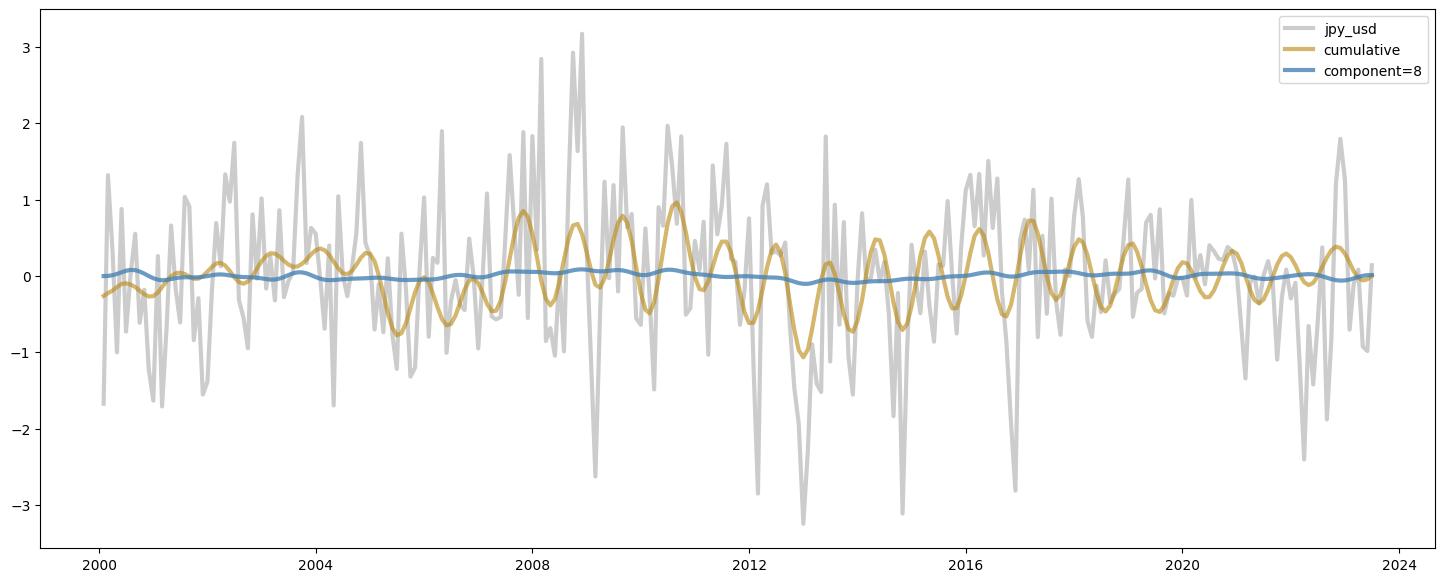

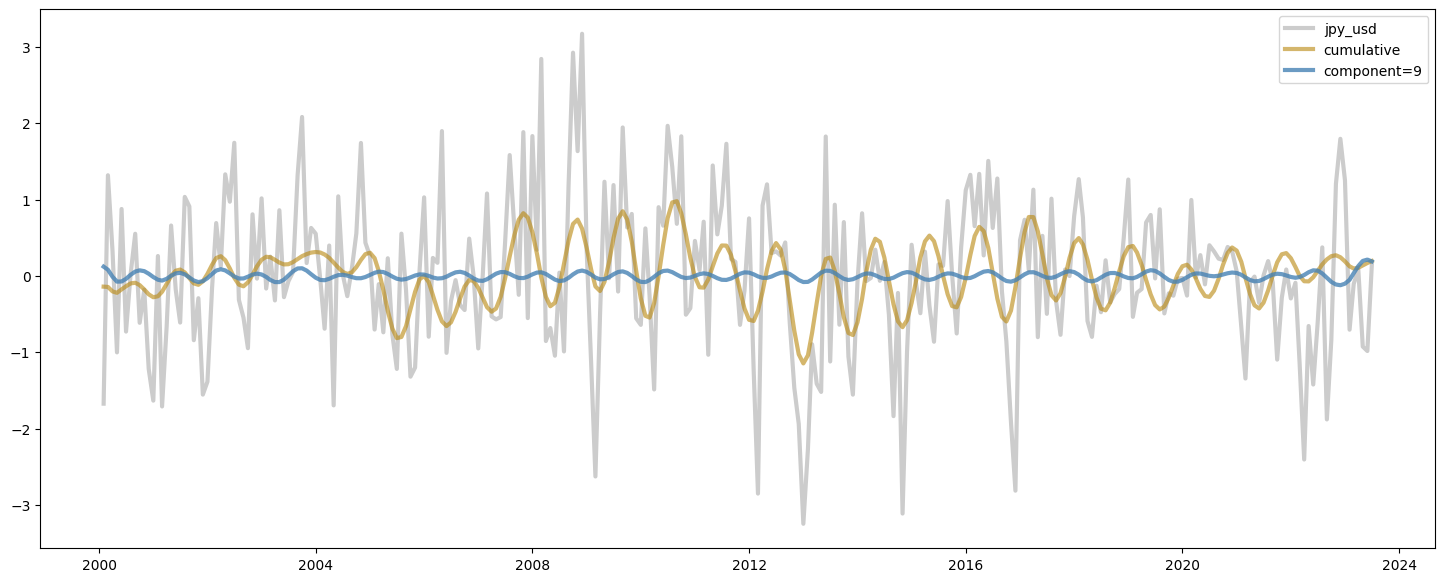

In [241]:
red_idx = 5
cumulative_recon = np.zeros_like(data.iloc[:, red_idx].values)

for comp in range(10):  
    fig, ax = plt.subplots(figsize=(18, 7))
    current_component = mssa.components_[red_idx, :, comp]
    cumulative_recon = cumulative_recon + current_component
    
    ax.plot(data.index, data.iloc[:, red_idx].values, lw=3, alpha=0.2, c='k', label=data.columns[red_idx])
    ax.plot(data.index, cumulative_recon, lw=3, c='darkgoldenrod', alpha=0.6, label='cumulative'.format(comp))
    ax.plot(data.index, current_component, lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    
    ax.legend()
    plt.show()

Для получения хороших результатов разложения на компоненты я сначала использовал приросты, а затем еще и скалировал их, чтобы ряд был более-менее стационарным

In [242]:
from statsmodels.tsa.api import VAR
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from pymssa import MSSA
import numpy as np

class PartialForecaster:

    def __init__(self, data: pd.DataFrame, target_feature: str, p: int | None = None):
        assert target_feature in data.columns
        self.data = data
        self.target_feature = target_feature
        self.p = p
        self.model = None
        self.is_mssa_fitted = False
        self.is_var_fitted = False

    def fit_mssa(self, window_size=None, n_components=None):
        diff_data = self.data.drop(columns=[self.target_feature]).diff().dropna()
        
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(diff_data)
        scaled_data_df = pd.DataFrame(scaled_data, columns=diff_data.columns, index=diff_data.index)
        
        self.mssa = MSSA(n_components=n_components, window_size=window_size, verbose=True)
        self.mssa.fit(scaled_data_df)
        
        mssa_components = np.hstack(self.mssa.components_)
        
        self.kernel_pca = KernelPCA(n_components=len(diff_data.columns), kernel='rbf')
        self.pca_components = self.kernel_pca.fit_transform(mssa_components)
        self.is_mssa_fitted = True
        return self.pca_components

    def fit_var(self):
        assert self.is_mssa_fitted, "MSSA must be fitted before fitting VAR"
        
        target_diff = self.data[self.target_feature].diff().dropna()

        if len(self.pca_components) != len(target_diff):
            raise ValueError("Mismatch in number of rows between target differences and PCA components.")

        pca_df = pd.DataFrame(self.pca_components, index=target_diff.index, columns=[f'PC{i+1}' for i in range(self.pca_components.shape[1])])
        
        combined_df = pd.concat([target_diff.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)
        self.combined_df = combined_df
        
        self.model = VAR(combined_df)
        if self.p is not None:
            self.model = self.model.fit(self.p)
        else:
            self.model = self.model.fit(ic='bic')
            self.p = self.model.k_ar
        self.is_var_fitted = True
    
    def p_define(self):
        return self.p


    def forecast(self, h=12):
        assert self.is_var_fitted, "VAR model must be fitted before forecasting"
        lag_order = self.model.k_ar
        result = self.model.forecast(self.combined_df.values[-lag_order:], steps=h)
        forecast = pd.Series(result[:, 0], index=pd.date_range(start=self.data.index[-1], periods=h+1, freq='M')[1:], name=self.target_feature)
        
        last_value = self.data[self.target_feature].iloc[-1]
        forecast_cumsum = forecast.cumsum()
        forecast = last_value + forecast_cumsum
        
        return forecast


In [243]:
model = PartialForecaster(df, 'gbr_usd')
model.fit_mssa()
model.fit_var()
model.forecast()

Constructing trajectory matrix
Trajectory matrix shape: (1410, 142)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


2023-08-31    1.293768
2023-09-30    1.295820
2023-10-31    1.319814
2023-11-30    1.412604
2023-12-31    1.507023
2024-01-31    1.563085
2024-02-29    1.623790
2024-03-31    1.715117
2024-04-30    1.790209
2024-05-31    1.824505
2024-06-30    1.862826
2024-07-31    1.938669
Freq: M, Name: gbr_usd, dtype: float64

In [244]:
def relative_score_partial(df, currency_columns, initial_window_size=247, step=6, horizon=12):
    relative_errors = {currency: [] for currency in currency_columns}  
    score = []

    for target_feature in currency_columns:
        initial_data = df.iloc[:initial_window_size]
        total_points = df.shape[0]
        
        model = PartialForecaster(initial_data, target_feature)
        model.fit_mssa()
        model.fit_var()
        best_p = model.p_define()
        
        metric_one = []
        
        for start in range(initial_window_size, total_points - horizon, step):
            train = df.iloc[:start]
            test = df.iloc[start:start + horizon]
            model = PartialForecaster(train, target_feature, p=best_p)
            model.fit_mssa()
            model.fit_var()

            forecast = model.forecast(horizon)
            actual = test[target_feature].values

            last_observed_value = train[target_feature].iloc[-1] 
            naive_forecast = pd.Series([last_observed_value] * horizon)

            absolute_error_model = np.abs(np.array(forecast) - np.array(actual))
            absolute_error_naive = np.abs(np.array(naive_forecast) - np.array(actual))

            error_ratio = absolute_error_model/absolute_error_naive

            relative_errors[target_feature].append(error_ratio)
        
    for currency in currency_columns:
        error_one = np.mean(np.array(relative_errors[currency]), axis=0)
        relative_errors[currency] = error_one

    error_df = pd.DataFrame(relative_errors, index=[f'Horizon {i+1}' for i in range(horizon)])
    return error_df 

score = relative_score_partial(df, currency_columns)

Constructing trajectory matrix
Trajectory matrix shape: (1230, 124)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1230, 124)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1260, 127)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1290, 130)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1320, 133)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1230, 124)
Decomposing 

C:\Users\rusta\AppData\Local\Temp\ipykernel_1640\447739016.py:32: RuntimeWarning: divide by zero encountered in divide
  error_ratio = absolute_error_model/absolute_error_naive


Constructing trajectory matrix
Trajectory matrix shape: (1290, 130)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1320, 133)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1230, 124)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1230, 124)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1260, 127)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1290, 130)
Decomposing 

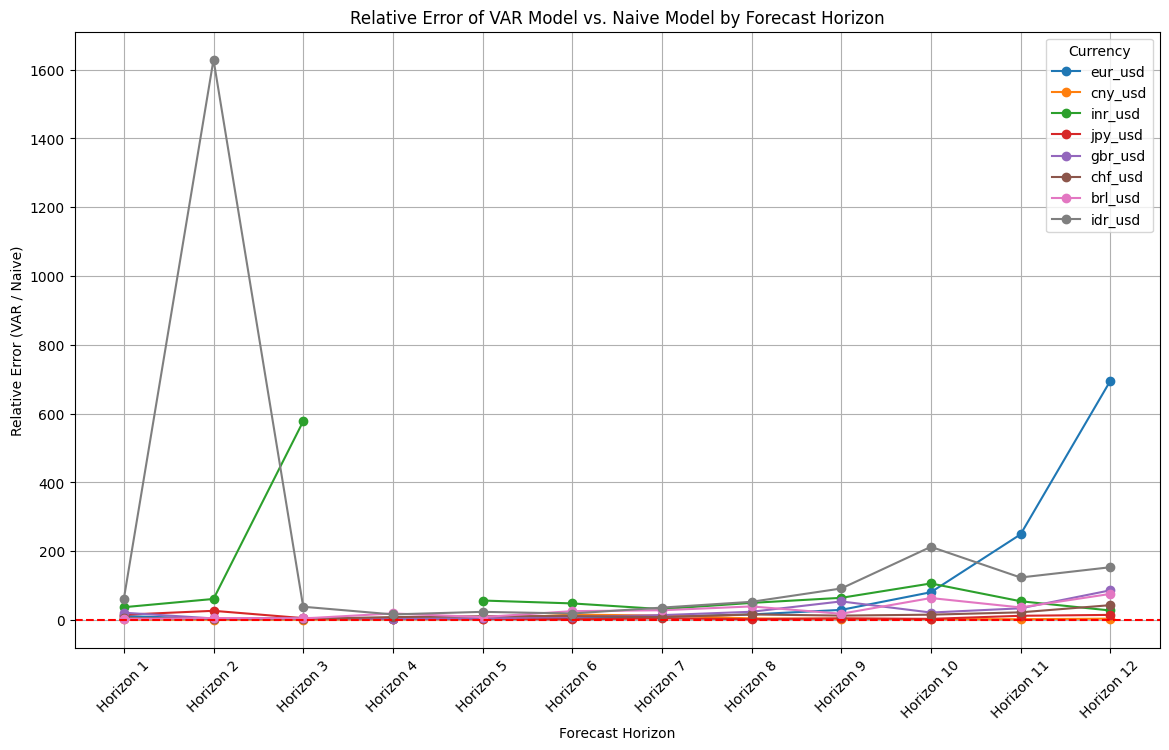

In [245]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for column in score.columns:
    plt.plot(score.index, score[column], marker='o', label=column)

plt.title('Relative Error of VAR Model vs. Naive Model by Forecast Horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('Relative Error (VAR / Naive)')
plt.legend(title='Currency')
plt.grid(True)
plt.xticks(rotation=45)


plt.axhline(y=1, color='r', linestyle='--')  

plt.show()

In [246]:
class EncoderDecoderForecaster:
    
    def __init__(self, data: pd.DataFrame, target_features: list, p: int | None = None):
        """
        __init__ Initializing forecaster class

        Arguments:
            data {pd.DataFrame} -- Dataframe of all data
            target_features {list} -- List of target features in the dataframe.
            p {int | None} -- Order of VAR model (optional)
        """
        self.data = data 
        self.target_features = target_features
        self.p = p

        self.is_mssa_fitted = False
        self.is_var_fitted = False
        self.is_decoder_fitted = False

        self.pca = None
        self.model = None
        self.model_fit = None
        self.pca_components = None
        self.decoders = {}

        
    def fit_mssa(self, window_size=12, n_components=0.95):
        """
        fit_mssa Fitting MSSA on the dataset

        Arguments:
            window_size {int} -- Window size for MSSA
            n_components {float} -- Proportion of variance to maintain in KernelPCA after MSSA

        Returns:
            pd.DataFrame -- DataFrame of principal components after KernelPCA
        """
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.data)
        data_df = pd.DataFrame(scaled_data, columns=self.data.columns, index=self.data.index)

        mssa = MSSA(window_size=window_size)
        mssa.fit(data_df)
        mssa_components = np.hstack(mssa.components_)

        self.pca = KernelPCA(n_components=len(self.data.columns), kernel='rbf')
        self.pca_components = self.pca.fit_transform(mssa_components)
        self.is_mssa_fitted = True
        return pd.DataFrame(self.pca_components, columns=[f'PC{i+1}' for i in range(self.pca_components.shape[1])])

    def fit_var(self):
        """
        Fitting VAR model on the results of PCA
        """
        assert self.is_mssa_fitted, "MSSA and KernelPCA must be fitted before fitting VAR"
        self.model = VAR(pd.DataFrame(self.pca_components))
        self.model_fit = self.model.fit(self.p, ic='bic')
        self.p = self.model_fit.k_ar
        self.is_var_fitted = True
        return self.p

    def fit_decoders(self):
        """
        Fit decoders for each target feature using GradientBoostingRegressor
        """
        assert self.is_mssa_fitted, "MSSA and KernelPCA must be fitted before fitting decoders"
        for feature in self.target_features:
            decoder = GradientBoostingRegressor()
            decoder.fit(self.pca_components, self.data[feature])
            self.decoders[feature] = decoder
        self.is_decoder_fitted = True

    def forecast(self, h=12):
        """
        Forecast using the VAR model and decode forecasts with decoder-models
        """
        assert self.is_var_fitted and self.is_decoder_fitted, "All models must be fitted before forecasting"
        forecast_pca = self.model_fit.forecast(self.pca_components[-self.model_fit.k_ar:], steps=h)
        forecast = {currency: self.decoders[currency].predict(forecast_pca) for currency in self.decoders}
        forecast_df = pd.DataFrame(forecast, index=[f'Horizon {i+1}' for i in range(h)])
        return forecast_df

In [247]:
model = EncoderDecoderForecaster(df, currency_columns)
model.fit_mssa()
model.fit_var()
model.fit_decoders()
model.forecast()

Constructing trajectory matrix
Trajectory matrix shape: (132, 272)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 30 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders


,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
Horizon 1,1.099509,0.141049,0.011996,0.737151,1.289863,1.139552,0.208016,0.000068
Horizon 2,1.095170,0.146748,0.012099,0.809279,1.313736,1.113123,0.203889,0.000068
Horizon 3,1.075328,0.153016,0.012248,0.855384,1.393648,1.111692,0.207748,0.000069
Horizon 4,1.125482,0.147004,0.013347,0.843965,1.300411,1.040924,0.201022,0.000069
Horizon 5,1.176880,0.150317,0.013996,0.842648,1.564433,1.043773,0.228909,0.000073
Horizon 6,1.298754,0.150314,0.014022,0.860144,1.665162,1.046304,0.239870,0.000081
Horizon 7,1.364560,0.151154,0.013999,1.007936,1.689993,1.057131,0.243321,0.000081
Horizon 8,1.372658,0.151104,0.014989,1.128437,1.708067,1.143987,0.308796,0.000083
Horizon 9,1.372658,0.151104,0.017061,1.128437,1.760391,1.147521,0.365679,0.000089
Horizon 10,1.372658,0.150788,0.017229,1.128437,1.760391,1.147521,0.376550,0.000108


In [248]:
def relative_cross_val_score_encoder_decoder(data: pd.DataFrame, initial_window_size: int, step: int, p:int, horizon: int = 12) -> pd.Series:
    """
    cross_val_score Estimating MAE cross-val score on a fitted model. Needed to get more sustainable MAE estimation

    Arguments:
        initial_window_size {int} -- Initial size of expanding window
        step {int} -- Step size of expanding window
        horizon {int} -- Forecasting horizon of cross-validation score
        p {int} -- order of VAR model
    Returns:
        pd.DataFrame -- Frame of absolute error by each horizon and each currency, averaged by several folds
    """
    total_points = data.shape[0]
    errors = [] 
    initial = data.iloc[:initial_window_size]
    first = EncoderDecoderForecaster(initial, currency_columns)
    first.fit_mssa()
    p_best = first.fit_var()
    print(p_best)
    


    for start in range(initial_window_size, total_points - horizon, step):
        train = data.iloc[:start]
        test = data.iloc[start:start + horizon]

        model = EncoderDecoderForecaster(train, currency_columns, p=p_best)
        model.fit_mssa()
        model.fit_var()
        model.fit_decoders()

        forecast = np.array(model.forecast(horizon))
        
        last_observed_value = train[currency_columns].iloc[-1]  

        naive_forecasts = np.array([last_observed_value] * horizon)

        y_test = np.array(test[currency_columns])


        model_errors = np.abs(forecast-y_test)
        naive_errors = np.abs(naive_forecasts-y_test)

        error_ratio = model_errors/naive_errors
        errors.append(error_ratio)
        
    stacked_matrices = np.stack(errors)
    average_matrix = np.mean(stacked_matrices, axis=0)

    return pd.DataFrame(average_matrix, index=[f'Horizon {i+1}' for i in range(horizon)], columns=currency_columns)

Constructing trajectory matrix
Trajectory matrix shape: (132, 236)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 28 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders
3
Constructing trajectory matrix
Trajectory matrix shape: (132, 236)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 28 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (132, 242)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 27 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders


C:\Users\rusta\AppData\Local\Temp\ipykernel_1640\2117937152.py:44: RuntimeWarning: divide by zero encountered in divide
  error_ratio = model_errors/naive_errors


Constructing trajectory matrix
Trajectory matrix shape: (132, 248)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 27 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (132, 254)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 28 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders


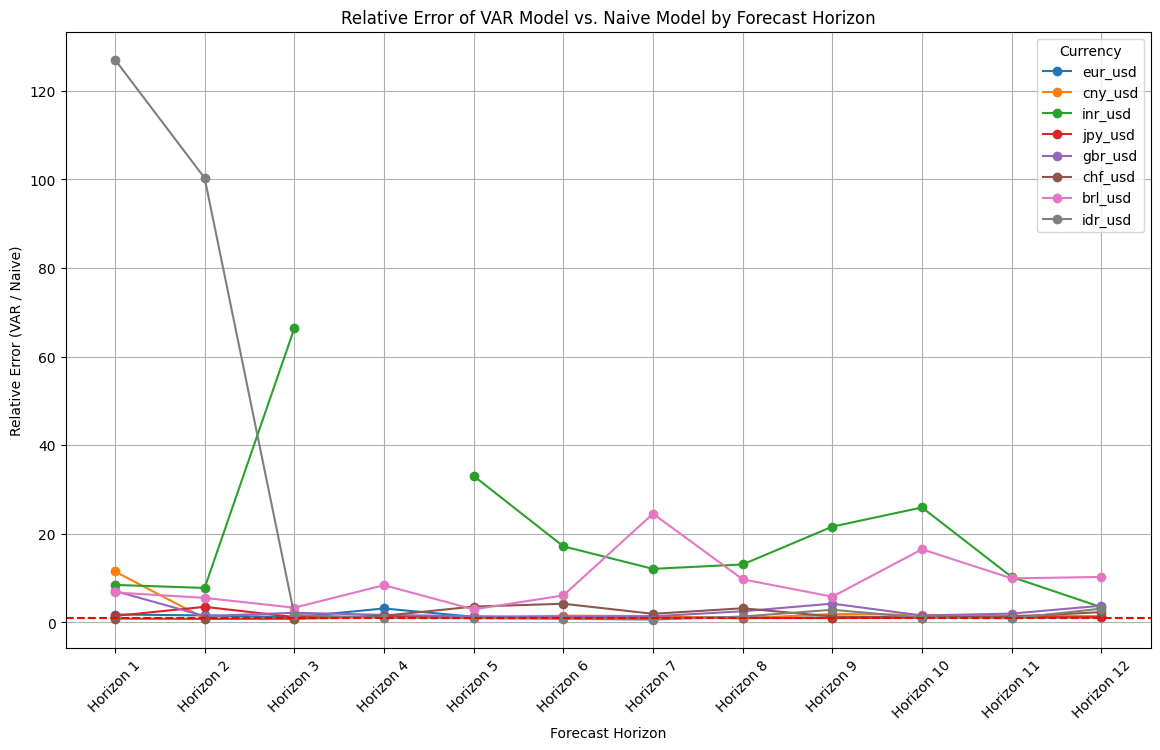

In [249]:
score = relative_cross_val_score_encoder_decoder(df, 247, 6, None, 12)
plt.figure(figsize=(14, 8))
for column in score.columns:
    plt.plot(score.index, score[column], marker='o', label=column)

plt.title('Relative Error of VAR Model vs. Naive Model by Forecast Horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('Relative Error (VAR / Naive)')
plt.legend(title='Currency')
plt.grid(True)
plt.xticks(rotation=45)


plt.axhline(y=1, color='r', linestyle='--')  

plt.show()

**Вывод**: Результаты сильно улучшим не получилось. Заметим, что в примере разложения одного конкретного ряда на компоненты, сложение компонент не приводит к получению итогового ряда, многие мелкие детали теряются, из-за чего ни в первой реализации, ни во второй, не получилось добиться лучшего результата, потому что в результатае такого отбора признаков большая часть информации о ряде теряется, а связано это с тем, что ряд соверешенно не стационарен и тут не помогает даже работа с абсолютными приростами. При этом также можно отметить, что закономерность с наихудшими результатами предсказания именно индийской и индонезийской рупии сохранилась.

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7